## Week 4 Day 4 - preparing the big project!

# The Sidekick

It's time to introduce:

1. Structured Outputs
2. A multi-agent flow

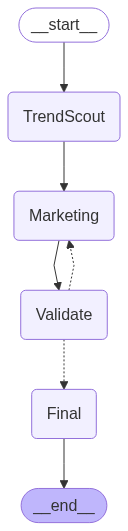

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d0a08156337cae2adc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
# -*- coding: utf-8 -*-
# pip install langgraph langchain-openai langchain-core gradio
# export OPENAI_API_KEY=...

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict
from langchain_core.runnables import RunnableLambda
from IPython.display import Image, display
import gradio as gr

# ===== LLM compartido =====
llm = ChatOpenAI(model="gpt-4o", temperature=0.3)

# ===== Estado =====
class State(TypedDict):
    brief: str                 # contexto de campaña / audiencia
    trends_digest: str         # lista 80/20 de hábitos
    email_proposal: str        # correo con un hábito desarrollado
    validation_feedback: str   # feedback del validador
    final_pack: str            # entrega final

# ===== Agente 1: TrendScout (PARETO 80/20) =====
def trends_agent(state: State) -> State:
    brief = state["brief"]
    prompt = f"""Sos un analista de hábitos con mentalidad 80/20 (Pareto).
Tu objetivo: identificar hábitos núcleo que generan resultados desproporcionados.

Contexto de campaña: {brief}

Entregá una lista breve (máx 5) de hábitos clave, cada uno con:
- Nombre breve
- Descripción (por qué es 80/20)
- Acción mínima viable
- Principio detrás (por qué funciona)
- Ejemplo de aplicación

Formato claro en español.
"""
    digest = llm.invoke(prompt).content
    state["trends_digest"] = digest
    return state

def marketing_agent(state: State) -> State:
    trends = state["trends_digest"]
    feedback_prev = state.get("validation_feedback", "")
    improve_clause = ""
    if feedback_prev and "no aprobado" in feedback_prev.lower():
        improve_clause = (
            "\nTake into account these validator recommendations for the new version:\n"
            f"{feedback_prev}\n"
        )

    mkt_prompt = f"""
You are an expert email copywriter for GrowRoutine, a personal growth brand.
From the list of 80/20 (Pareto) habits below, choose EXACTLY ONE habit and write a motivational and practical email that helps the reader improve by 1% each day.

HABITS TO CHOOSE FROM:
{trends}
{improve_clause}

Follow this EXACT structure and constraints:

1) Subject: ≤55 characters, clear, intriguing, no empty clickbait.
2) Greeting: "Hola [Nombre],"
3) Hook: 2–3 short lines contrasting a common belief with a deeper truth.
4) Transition Insight: 1–2 sentences stating that small, consistent actions are the key.
5) Introduce the habit:
   - Start with "📌 Prueba este hábito:"
   - Explain the habit in ONE clear sentence.
   - Provide 3–5 short, concrete steps to perform it.
6) Why It Works: 1–2 sentences (emotional + logical principle behind the habit).
7) Book Reference: include "📖 " + Book Title – Author (relevant to the habit).
8) Weekly Challenge:
   - Start with "💡 Reto de la semana:"
   - Give a 7-day measurable action to apply the habit.
9) Community CTA (ALWAYS include this exact line verbatim):
   "Recuerda que si deseas etiquetarnos en instagram @growroutine así nos motivamos todos, no somos un club de hábitos, somos una comunidad que camina en la misma direción!"
10) Final CTA: Invite the reader to reply and share progress.
11) Signature: "Creciendo 1% cada día,\nAlejandro B."

Language & tone:
- Write in clear, concise Spanish.
- Motivational, friendly, and practical.
- Total length between 140 and 220 words.

OUTPUT FORMAT (must match exactly):
Asunto:
<subject>
Preheader:
<short preheader (≤70 chars)>
Cuerpo:
<full email body following the structure above, with line breaks>
""".strip()

    result = llm.invoke(mkt_prompt)
    state["email_proposal"] = result.content
    return state


# ===== Agente 3: Validador =====
def validator_agent(state: State) -> State:
    email = state["email_proposal"]
    trends = state["trends_digest"]

    val_prompt = f"""Sos un revisor top 1% de mentalidad y hábitos.
Validá el correo según:
1) Usa solo 1 hábito 80/20 de la lista base.
2) Sigue estructura del ejemplo (asunto, preheader, hook, pasos, por qué funciona, libro, reto, firma).
3) Claridad, utilidad y aplicabilidad inmediata.
4) Longitud total razonable (140–220 palabras).
5) Energía positiva y CTA claro.

Devuelve en formato:
Estado: Aprobado | No aprobado
Feedback:
- ...
Recomendaciones (solo si No aprobado):
- ...
---
Hábitos base:
{trends}

Propuesta:
{email}
"""
    state["validation_feedback"] = llm.invoke(val_prompt).content
    return state

# ===== Decisor =====
def should_rerun_marketing(state: State) -> str:
    fb = (state.get("validation_feedback") or "").lower()
    if "no aprobado" in fb:
        return "Marketing"
    return "Final"

# ===== Entrega Final =====
def final_pack(state: State) -> State:
    pack_prompt = f"""Convertí en un entregable final limpio (Markdown):
# Hábito 80/20 elegido – Resumen base
{state['trends_digest']}

# Email aprobado
{state['email_proposal']}

# Validación
{state['validation_feedback']}
"""
    state["final_pack"] = llm.invoke(pack_prompt).content
    return state

# ===== Grafo =====
builder = StateGraph(State)
builder.add_node("TrendScout", RunnableLambda(trends_agent))
builder.add_node("Marketing", RunnableLambda(marketing_agent))
builder.add_node("Validate", RunnableLambda(validator_agent))
builder.add_node("Final", RunnableLambda(final_pack))

builder.set_entry_point("TrendScout")
builder.add_edge("TrendScout", "Marketing")
builder.add_edge("Marketing", "Validate")
builder.add_conditional_edges("Validate", should_rerun_marketing, {
    "Marketing": "Marketing",
    "Final": "Final"
})
builder.add_edge("Final", END)

graph = builder.compile(checkpointer=MemorySaver())

# Visual opcional
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

# ===== Interfaz Gradio =====
def run_pipeline(brief):
    result = graph.invoke({"brief": brief}, config={"configurable": {"thread_id": "habit-run"}})
    return (
        result.get("trends_digest", ""),
        result.get("email_proposal", ""),
        result.get("validation_feedback", ""),
        result.get("final_pack", "")
    )

with gr.Blocks() as demo:
    gr.Markdown("## 📈 Un hábito 80/20 → Email GrowRoutine")
    brief_in = gr.Textbox(
        label="🧩 Contexto (audiencia/objetivo/oferta)",
        lines=3,
        placeholder="Ej: Audiencia: emprendedores ocupados. Objetivo: aumentar engagement en newsletter."
    )
    run_btn = gr.Button("🚀 Generar Email de 1 Hábito")

    trends_out = gr.Textbox(label="🧠 Hábitos 80/20 detectados", lines=12)
    email_out = gr.Textbox(label="✉️ Email propuesto", lines=20)
    val_out = gr.Textbox(label="✅ Validación", lines=14)
    final_out = gr.Textbox(label="📦 Entrega Final (si aprobado)", lines=14)

    run_btn.click(
        fn=run_pipeline,
        inputs=[brief_in],
        outputs=[trends_out, email_out, val_out, final_out]
    )

demo.launch(share=True)
